In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlineretail/OnlineRetail.csv


### Load packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Load the dataset

In [6]:
df=pd.read_csv(r"../input/onlineretail/OnlineRetail.csv", encoding="cp1252")

In [8]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [13]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

### Product Analytics

**Quantity Distribution**

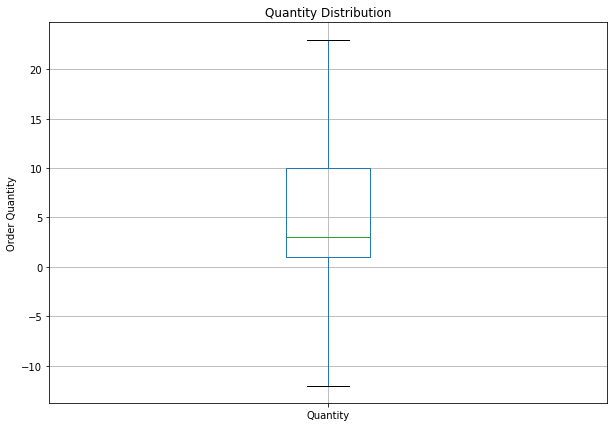

In [9]:
ax = df['Quantity'].plot.box(
    showfliers=False,
    grid=True,
    figsize=(10, 7)
)

ax.set_ylabel('Order Quantity')
ax.set_title('Quantity Distribution')

plt.suptitle("")
plt.show()

In [10]:
pd.DataFrame(df['Quantity'].describe())

,Quantity
count,541909.000000
mean,9.552250
std,218.081158
min,-80995.000000
25%,1.000000
50%,3.000000
75%,10.000000
max,80995.000000


As you can see from this plot, some orders have negative quantities. This is because the cancelled or refunded orders are recorded with negative values in the Quantity column of our dataset. For illustration purposes in this exercise, we are going to disregard the cancelled orders. 

In [11]:
df = df.loc[df['Quantity'] > 0]

**Time-series Number of Orders**

In [17]:
df['InvoiceDate']=pd.to_datetime(df.InvoiceDate)

In [20]:
monthly_orders_df = df.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()

In [21]:
monthly_orders_df

InvoiceDate
2010-12-31    1629
2011-01-31    1120
2011-02-28    1126
2011-03-31    1531
2011-04-30    1318
2011-05-31    1731
2011-06-30    1576
2011-07-31    1540
2011-08-31    1409
2011-09-30    1896
2011-10-31    2129
2011-11-30    2884
2011-12-31     839
Freq: M, Name: InvoiceNo, dtype: int64

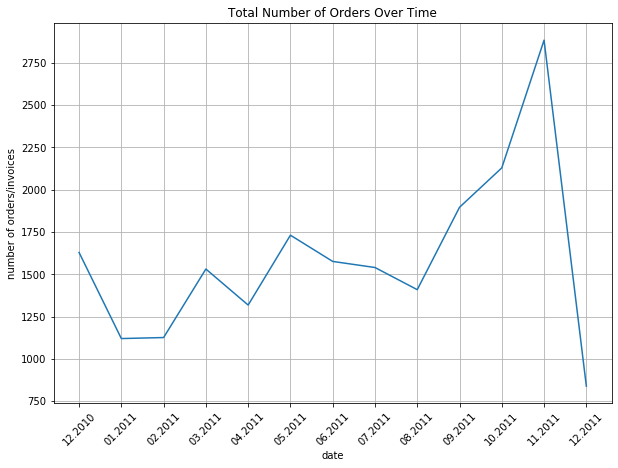

In [22]:
ax = pd.DataFrame(monthly_orders_df.values).plot(
    grid=True,
    figsize=(10,7),
    legend=False
)

ax.set_xlabel('date')
ax.set_ylabel('number of orders/invoices')
ax.set_title('Total Number of Orders Over Time')

plt.xticks(
    range(len(monthly_orders_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_orders_df.index], 
    rotation=45
)

plt.show()

there is a sudden radical drop in the number of orders in December 2011. If you look closely at the data, this is simply because we do not have the data for the full month of December 2011. We can verify this by using the following code

In [23]:
invoice_dates = df.loc[
    df['InvoiceDate'] >= '2011-12-01',
    'InvoiceDate'
]

print('Min date: %s\nMax date: %s' % (invoice_dates.min(), invoice_dates.max()))

Min date: 2011-12-01 08:33:00
Max date: 2011-12-09 12:50:00


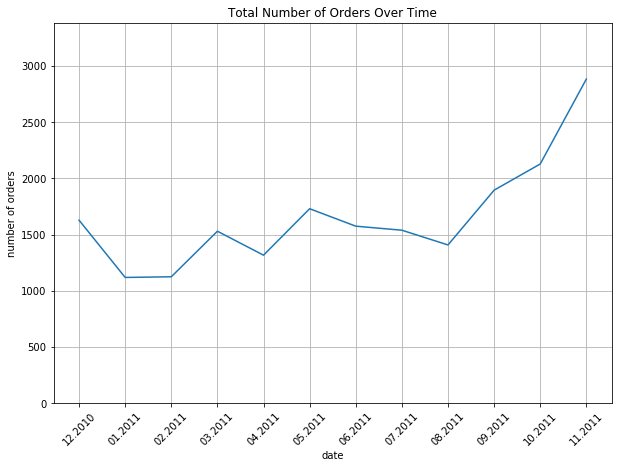

In [24]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']
monthly_orders_df = df.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()
ax = pd.DataFrame(monthly_orders_df.values).plot(
    grid=True,
    figsize=(10,7),
    legend=False
)

ax.set_xlabel('date')
ax.set_ylabel('number of orders')
ax.set_title('Total Number of Orders Over Time')

ax.set_ylim([0, max(monthly_orders_df.values)+500])

plt.xticks(
    range(len(monthly_orders_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_orders_df.index], 
    rotation=45
)

plt.show()

**Time-series Revenue**

In [25]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
monthly_revenue_df = df.set_index('InvoiceDate')['Sales'].resample('M').sum()
monthly_revenue_df


InvoiceDate
2010-12-31     823746.140
2011-01-31     691364.560
2011-02-28     523631.890
2011-03-31     717639.360
2011-04-30     537808.621
2011-05-31     770536.020
2011-06-30     761739.900
2011-07-31     719221.191
2011-08-31     737014.260
2011-09-30    1058590.172
2011-10-31    1154979.300
2011-11-30    1509496.330
Freq: M, Name: Sales, dtype: float64

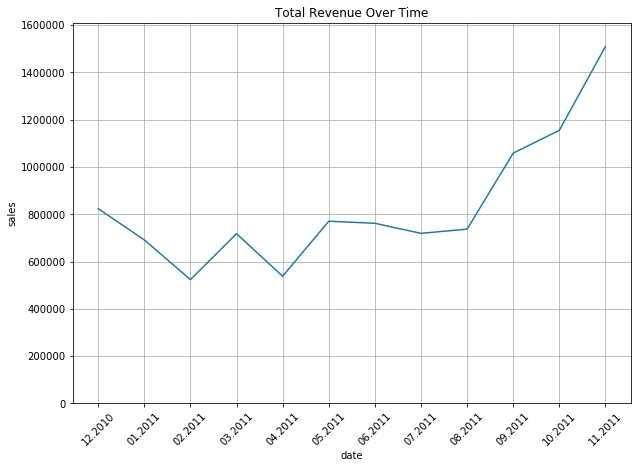

In [26]:
ax = pd.DataFrame(monthly_revenue_df.values).plot(
    grid=True,
    figsize=(10,7),
    legend=False
)

ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.set_title('Total Revenue Over Time')

ax.set_ylim([0, max(monthly_revenue_df.values)+100000])

plt.xticks(
    range(len(monthly_revenue_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_revenue_df.index], 
    rotation=45
)

plt.show()

**time-series Repeat Customers**

In [27]:
invoice_customer_df = df.groupby(
    by=['InvoiceNo', 'InvoiceDate']
).agg({
    'Sales': sum,
    'CustomerID': max,
    'Country': max,
}).reset_index()

In [28]:
invoice_customer_df.head()

,InvoiceNo,InvoiceDate,Sales,CustomerID,Country
0,536365,2010-12-01 08:26:00,139.12,17850.0,United Kingdom
1,536366,2010-12-01 08:28:00,22.20,17850.0,United Kingdom
2,536367,2010-12-01 08:34:00,278.73,13047.0,United Kingdom
3,536368,2010-12-01 08:34:00,70.05,13047.0,United Kingdom
4,536369,2010-12-01 08:35:00,17.85,13047.0,United Kingdom


In [29]:
monthly_repeat_customers_df = invoice_customer_df.set_index('InvoiceDate').groupby([
    pd.Grouper(freq='M'), 'CustomerID'
]).filter(lambda x: len(x) > 1).resample('M').nunique()['CustomerID']

monthly_repeat_customers_df


InvoiceDate
2010-12-31    263
2011-01-31    153
2011-02-28    153
2011-03-31    203
2011-04-30    170
2011-05-31    281
2011-06-30    220
2011-07-31    227
2011-08-31    198
2011-09-30    272
2011-10-31    324
2011-11-30    541
Freq: M, Name: CustomerID, dtype: int64

Let's take a closer look at the groupby function in this code. Here, we group by two conditions—pd.Grouper(freq='M') and CustomerID. The first groupby condition, pd.Grouper(freq='M'), groups the data by the index, InvoiceDate, into each month. Then, we group this data by each CustomerID. Using the filter function, we can subselect the data by a custom rule. Here, the filtering rule, lambda x: len(x) > 1, means we want to retrieve those with more than one record in the group. In other words, we want to retrieve only those customers with more than one order in a given month. Lastly, we resample and aggregate by each month and count the number of unique customers in each month by using resample('M') and nunique

In [31]:
monthly_unique_customers_df = df.set_index('InvoiceDate')['CustomerID'].resample('M').nunique()
monthly_unique_customers_df


InvoiceDate
2010-12-31     886
2011-01-31     742
2011-02-28     759
2011-03-31     975
2011-04-30     857
2011-05-31    1057
2011-06-30     992
2011-07-31     950
2011-08-31     936
2011-09-30    1267
2011-10-31    1365
2011-11-30    1666
Freq: M, Name: CustomerID, dtype: int64

In [32]:
monthly_repeat_percentage = monthly_repeat_customers_df/monthly_unique_customers_df*100.0
monthly_repeat_percentage

InvoiceDate
2010-12-31    29.683973
2011-01-31    20.619946
2011-02-28    20.158103
2011-03-31    20.820513
2011-04-30    19.836639
2011-05-31    26.584674
2011-06-30    22.177419
2011-07-31    23.894737
2011-08-31    21.153846
2011-09-30    21.468035
2011-10-31    23.736264
2011-11-30    32.472989
Freq: M, Name: CustomerID, dtype: float64

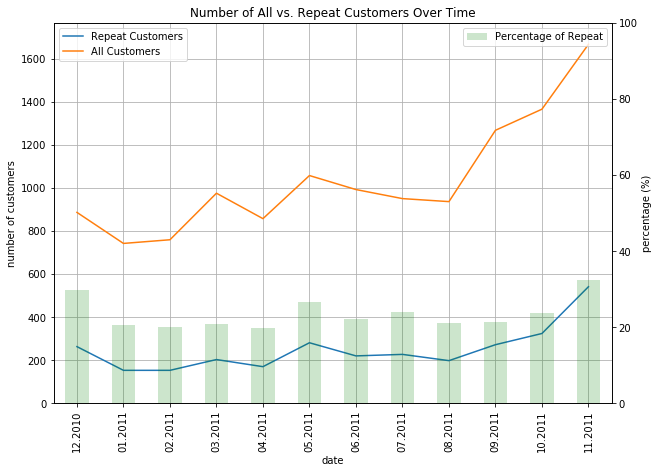

In [33]:
ax = pd.DataFrame(monthly_repeat_customers_df.values).plot(
    figsize=(10,7)
)

pd.DataFrame(monthly_unique_customers_df.values).plot(
    ax=ax,
    grid=True
)


ax2 = pd.DataFrame(monthly_repeat_percentage.values).plot.bar(
    ax=ax,
    grid=True,
    secondary_y=True,
    color='green',
    alpha=0.2
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('Number of All vs. Repeat Customers Over Time')

ax2.set_ylabel('percentage (%)')

ax.legend(['Repeat Customers', 'All Customers'])
ax2.legend(['Percentage of Repeat'], loc='upper right')

ax.set_ylim([0, monthly_unique_customers_df.values.max()+100])
ax2.set_ylim([0, 100])

plt.xticks(
    range(len(monthly_repeat_customers_df.index)), 
    [x.strftime('%m.%Y') for x in monthly_repeat_customers_df.index], 
    rotation=45
)

plt.show()

**Revenue from Repeat Customers**

In [34]:
monthly_rev_repeat_customers_df = invoice_customer_df.set_index('InvoiceDate').groupby([
    pd.Grouper(freq='M'), 'CustomerID'
]).filter(lambda x: len(x) > 1).resample('M').sum()['Sales']

In [35]:
monthly_rev_perc_repeat_customers_df = monthly_rev_repeat_customers_df/monthly_revenue_df * 100.0
monthly_rev_repeat_customers_df

InvoiceDate
2010-12-31    359170.60
2011-01-31    222124.00
2011-02-28    191229.37
2011-03-31    267390.48
2011-04-30    195474.18
2011-05-31    378197.04
2011-06-30    376307.26
2011-07-31    317475.00
2011-08-31    317134.25
2011-09-30    500663.36
2011-10-31    574006.87
2011-11-30    713775.85
Freq: M, Name: Sales, dtype: float64

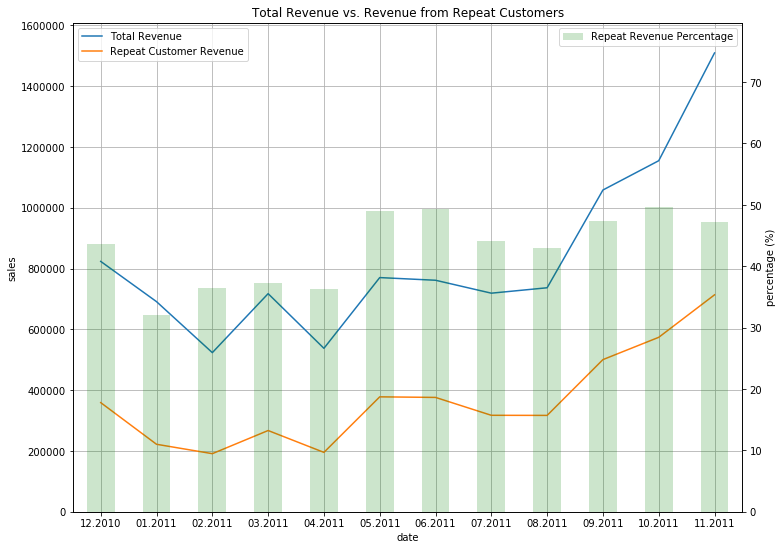

In [36]:
ax = pd.DataFrame(monthly_revenue_df.values).plot(figsize=(12,9))

pd.DataFrame(monthly_rev_repeat_customers_df.values).plot(
    ax=ax,
    grid=True,
)

ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.set_title('Total Revenue vs. Revenue from Repeat Customers')

ax.legend(['Total Revenue', 'Repeat Customer Revenue'])

ax.set_ylim([0, max(monthly_revenue_df.values)+100000])

ax2 = ax.twinx()

pd.DataFrame(monthly_rev_perc_repeat_customers_df.values).plot(
    ax=ax2,
    kind='bar',
    color='g',
    alpha=0.2
)

ax2.set_ylim([0, max(monthly_rev_perc_repeat_customers_df.values)+30])
ax2.set_ylabel('percentage (%)')
ax2.legend(['Repeat Revenue Percentage'])

ax2.set_xticklabels([
    x.strftime('%m.%Y') for x in monthly_rev_perc_repeat_customers_df.index
])

plt.show()

**Popular Items Over Time**

In [38]:

date_item_df = pd.DataFrame(
    df.set_index('InvoiceDate').groupby([
        pd.Grouper(freq='M'), 'StockCode'
    ])['Quantity'].sum()
)
date_item_df.head()

Quantity
InvoiceDate StockCode          
2010-12-31  10002           251
            10120            16
            10123C            1
            10124A            4
            10124G            5

In [39]:

# Rank items by the last month sales
last_month_sorted_df = date_item_df.loc['2011-11-30'].sort_values(
    by='Quantity', ascending=False
).reset_index()

last_month_sorted_df

,InvoiceDate,StockCode,Quantity
0,2011-11-30,23084,14954
1,2011-11-30,84826,12551
2,2011-11-30,22197,12460
3,2011-11-30,22086,7908
4,2011-11-30,85099B,5909
...,...,...,...
2941,2011-11-30,17129F,1
2942,2011-11-30,85049c,1
2943,2011-11-30,85114b,1
2944,2011-11-30,85129C,1


In [40]:
# Regroup for top 5 items
date_item_df = pd.DataFrame(
    df.loc[
        df['StockCode'].isin(['23084', '84826', '22197', '22086', '85099B'])
    ].set_index('InvoiceDate').groupby([
        pd.Grouper(freq='M'), 'StockCode'
    ])['Quantity'].sum()
)
date_item_df

,,Quantity
InvoiceDate,StockCode,
2010-12-31,85099B,2152
2011-01-31,85099B,2747
2011-02-28,85099B,3080
2011-03-31,85099B,5282
2011-04-30,85099B,2456
2011-05-31,85099B,3621
2011-06-30,85099B,3682
2011-07-31,85099B,3129
2011-08-31,85099B,5502


In [41]:

trending_itmes_df = date_item_df.reset_index().pivot('InvoiceDate','StockCode').fillna(0)

trending_itmes_df = trending_itmes_df.reset_index()
trending_itmes_df = trending_itmes_df.set_index('InvoiceDate')
trending_itmes_df.columns = trending_itmes_df.columns.droplevel(0)

trending_itmes_df

StockCode,85099B
InvoiceDate,
2010-12-31,2152
2011-01-31,2747
2011-02-28,3080
2011-03-31,5282
2011-04-30,2456
2011-05-31,3621
2011-06-30,3682
2011-07-31,3129
2011-08-31,5502


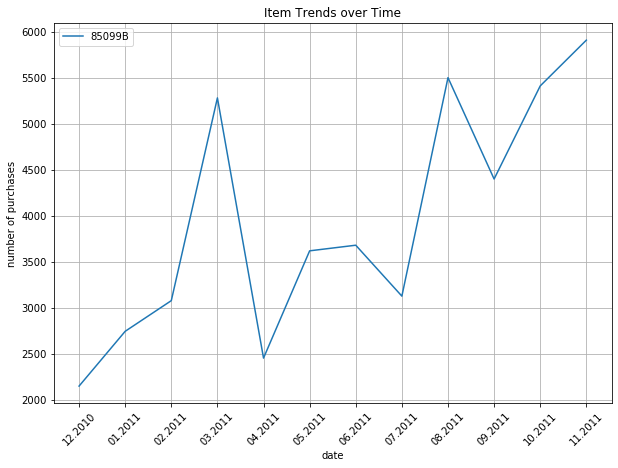

In [43]:
ax = pd.DataFrame(trending_itmes_df.values).plot(
    figsize=(10,7),
    grid=True,
)

ax.set_ylabel('number of purchases')
ax.set_xlabel('date')
ax.set_title('Item Trends over Time')

ax.legend(trending_itmes_df.columns, loc='upper left')

plt.xticks(
    range(len(trending_itmes_df.index)), 
    [x.strftime('%m.%Y') for x in trending_itmes_df.index], 
    rotation=45
)

plt.show()